In [114]:
import pickle
import pandas as pd
import numpy as np
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Flatten,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy
%matplotlib inline

In [115]:
training_file = "../input/german-traffic-dataset/train.p"
validation_file= "../input/german-traffic-dataset/valid.p"
testing_file = "../input/german-traffic-dataset/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [116]:
# Mapping ClassID to traffic sign names
signs = []
with open('../input/german-sign/signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

In [117]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples
n_test = X_test.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples: ", n_train)
print("Number of testing examples: ", n_test)
print("Number of validation examples: ", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples:  34799
Number of testing examples:  12630
Number of validation examples:  4410
Image data shape = (32, 32, 3)
Number of classes = 43


In [118]:
X_train, y_train = shuffle(X_train, y_train)
X_valid,y_valid = shuffle(X_valid,y_valid)
X_test,y_test = shuffle(X_test,y_test)

In [124]:
def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),15,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    #img = cv2.warpAffine(img,M_aff,(cols,rows))
    
    # Bilateral filtering
    img = cv2.bilateralFilter(img,9,75,75)
    return img

In [104]:
def image_rotate(image):
  (h, w) = image.shape[:2]
  (cX,cY) = (w//2, h//2)
  # rotate our image by 45 degrees around the center of the image
  M = cv2.getRotationMatrix2D((cX, cY),5,1.0)
  rotated = cv2.warpAffine(image, M, (w, h))
  return rotated

In [120]:
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [121]:
def local_histo_equalize(image):
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

In [122]:
def preprocess(data):
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1],n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = np.divide(img,255)
    normalized_images = normalized_images[..., None]
    return normalized_images
  

In [123]:
def test_preprocess(data):
    data = cv2.resize(data,(32,32))
    image = gray_scale(data)
    equal_img = local_histo_equalize(image)
    norm_img = np.divide(equal_img,255)
    final_image = norm_img.reshape((1,32,32,1))
    return final_image

In [125]:
classes = 43

X_train_final = X_train
y_train_final = y_train
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 4000
    if class_records != max_records:
        ovr_sample = max_records - class_records
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug

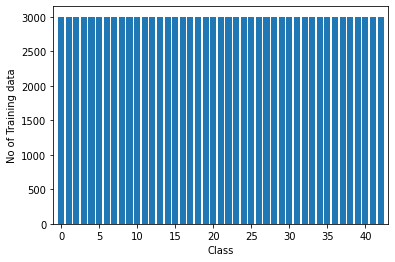

In [110]:
unique_elements, counts_elements = np.unique(y_train_final, return_counts = True)

plt.bar( np.arange( 43 ), counts_elements, align='center')
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 43])
plt.show()

In [126]:
X_train_final, y_train_final = shuffle(X_train_final, y_train_final)
X_valid,y_valid = shuffle(X_valid,y_valid)
X_test,y_test = shuffle(X_test,y_test)

In [127]:
X_train_preprocessed = preprocess(X_train_final)
X_valid_preprocessed = preprocess(X_valid)

In [128]:
X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32,32,1).astype('float32')
X_valid_preprocessed_dn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32,32,1).astype('float32')

In [ ]:
y_train_final_dn = tf.keras.utils.to_categorical(y_train_final, n_classes)
y_valid_final_dn = tf.keras.utils.to_categorical(y_valid, n_classes)

In [ ]:
y_test_final_dn = tf.keras.utils.to_categorical(y_test, n_classes)

In [ ]:
print(X_train_preprocessed_dn.shape)
print(X_valid_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_valid_final_dn.shape)

In [130]:
model_conv = Sequential()
## If You preprocessed with gray scaling and local histogram equivalization then input_shape = (32,32,1) else (32,32,3)
model_conv.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(32, 32, 1)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model_conv.add(Dropout(0.25))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model_conv.add(Dropout(0.5))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dropout(0.3))
model_conv.add(Dense(n_classes, activation='softmax'))

In [131]:
model_conv.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 4, 4, 128)        

In [133]:
model_conv.compile(optimizer=Adam(learning_rate=0.0002),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [135]:
history = model_conv.fit(X_train_preprocessed_dn,y_train_final, batch_size=64, epochs=30, verbose=1,validation_data=(X_valid_preprocessed_dn,y_valid))

Epoch 1/30
2688/2688 [==============================] - 18s 6ms/step - loss: 3.2946 - accuracy: 0.1179 - val_loss: 1.2754 - val_accuracy: 0.6444
Epoch 2/30
2688/2688 [==============================] - 17s 6ms/step - loss: 1.2931 - accuracy: 0.5819 - val_loss: 0.5562 - val_accuracy: 0.8404
Epoch 3/30
2688/2688 [==============================] - 17s 6ms/step - loss: 0.7328 - accuracy: 0.7630 - val_loss: 0.3080 - val_accuracy: 0.9132
Epoch 4/30
2688/2688 [==============================] - 17s 6ms/step - loss: 0.4927 - accuracy: 0.8429 - val_loss: 0.1967 - val_accuracy: 0.9499
Epoch 5/30
2688/2688 [==============================] - 17s 6ms/step - loss: 0.3765 - accuracy: 0.8818 - val_loss: 0.1424 - val_accuracy: 0.9585
Epoch 6/30
2688/2688 [==============================] - 17s 6ms/step - loss: 0.3065 - accuracy: 0.9033 - val_loss: 0.1263 - val_accuracy: 0.9592
Epoch 7/30
2688/2688 [==============================] - 18s 7ms/step - loss: 0.2602 - accuracy: 0.9178 - val_loss: 0.1060 - val_ac

In [136]:
X_test_preprocessed = preprocess(X_test)

In [137]:
y_prob = model_conv.predict(X_test_preprocessed)
y_pred = model_conv.predict_classes(X_test_preprocessed)

In [138]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [139]:
metric = {'Accuracy':acc,'Loss':loss,'Val_accuracy':val_acc,'Val_loss':val_loss}
metric_data = pd.DataFrame(metric)

<AxesSubplot:>

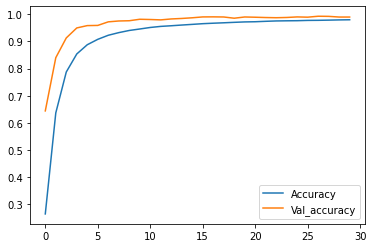

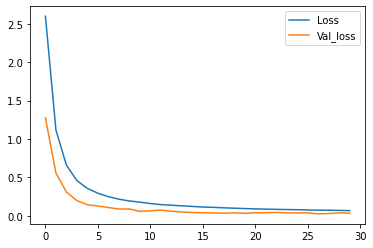

In [140]:
metric_data[['Accuracy','Val_accuracy']].plot()
metric_data[['Loss','Val_loss']].plot()

In [142]:
model_conv.evaluate(X_test_preprocessed,y_test)

395/395 [==============================] - 1s 2ms/step - loss: 0.0952 - accuracy: 0.9739


[0.09516970068216324, 0.9738717079162598]

In [152]:
model_conv.save("traffic.h5")

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.99      0.99      0.99       720
           2       0.99      1.00      0.99       750
           3       0.99      0.92      0.95       450
           4       0.98      0.99      0.99       660
           5       0.94      0.99      0.97       630
           6       0.99      0.95      0.97       150
           7       0.99      0.99      0.99       450
           8       0.98      0.99      0.99       450
           9       0.98      1.00      0.99       480
          10       0.99      1.00      1.00       660
          11       0.95      0.93      0.94       420
          12       0.99      0.98      0.99       690
          13       0.99      1.00      0.99       720
          14       0.94      0.98      0.96       270
          15       0.99      0.99      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

<AxesSubplot:>

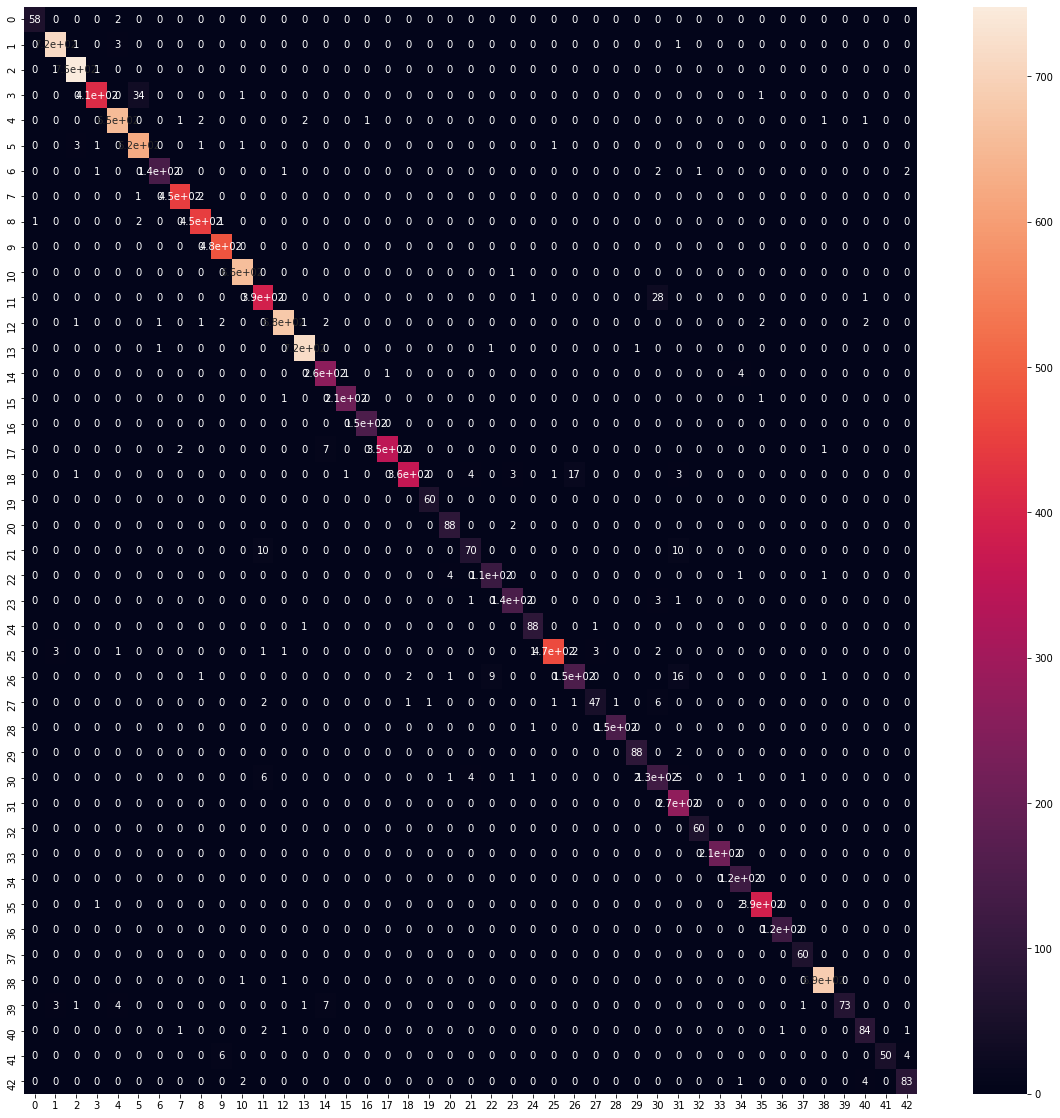

In [143]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot = True)

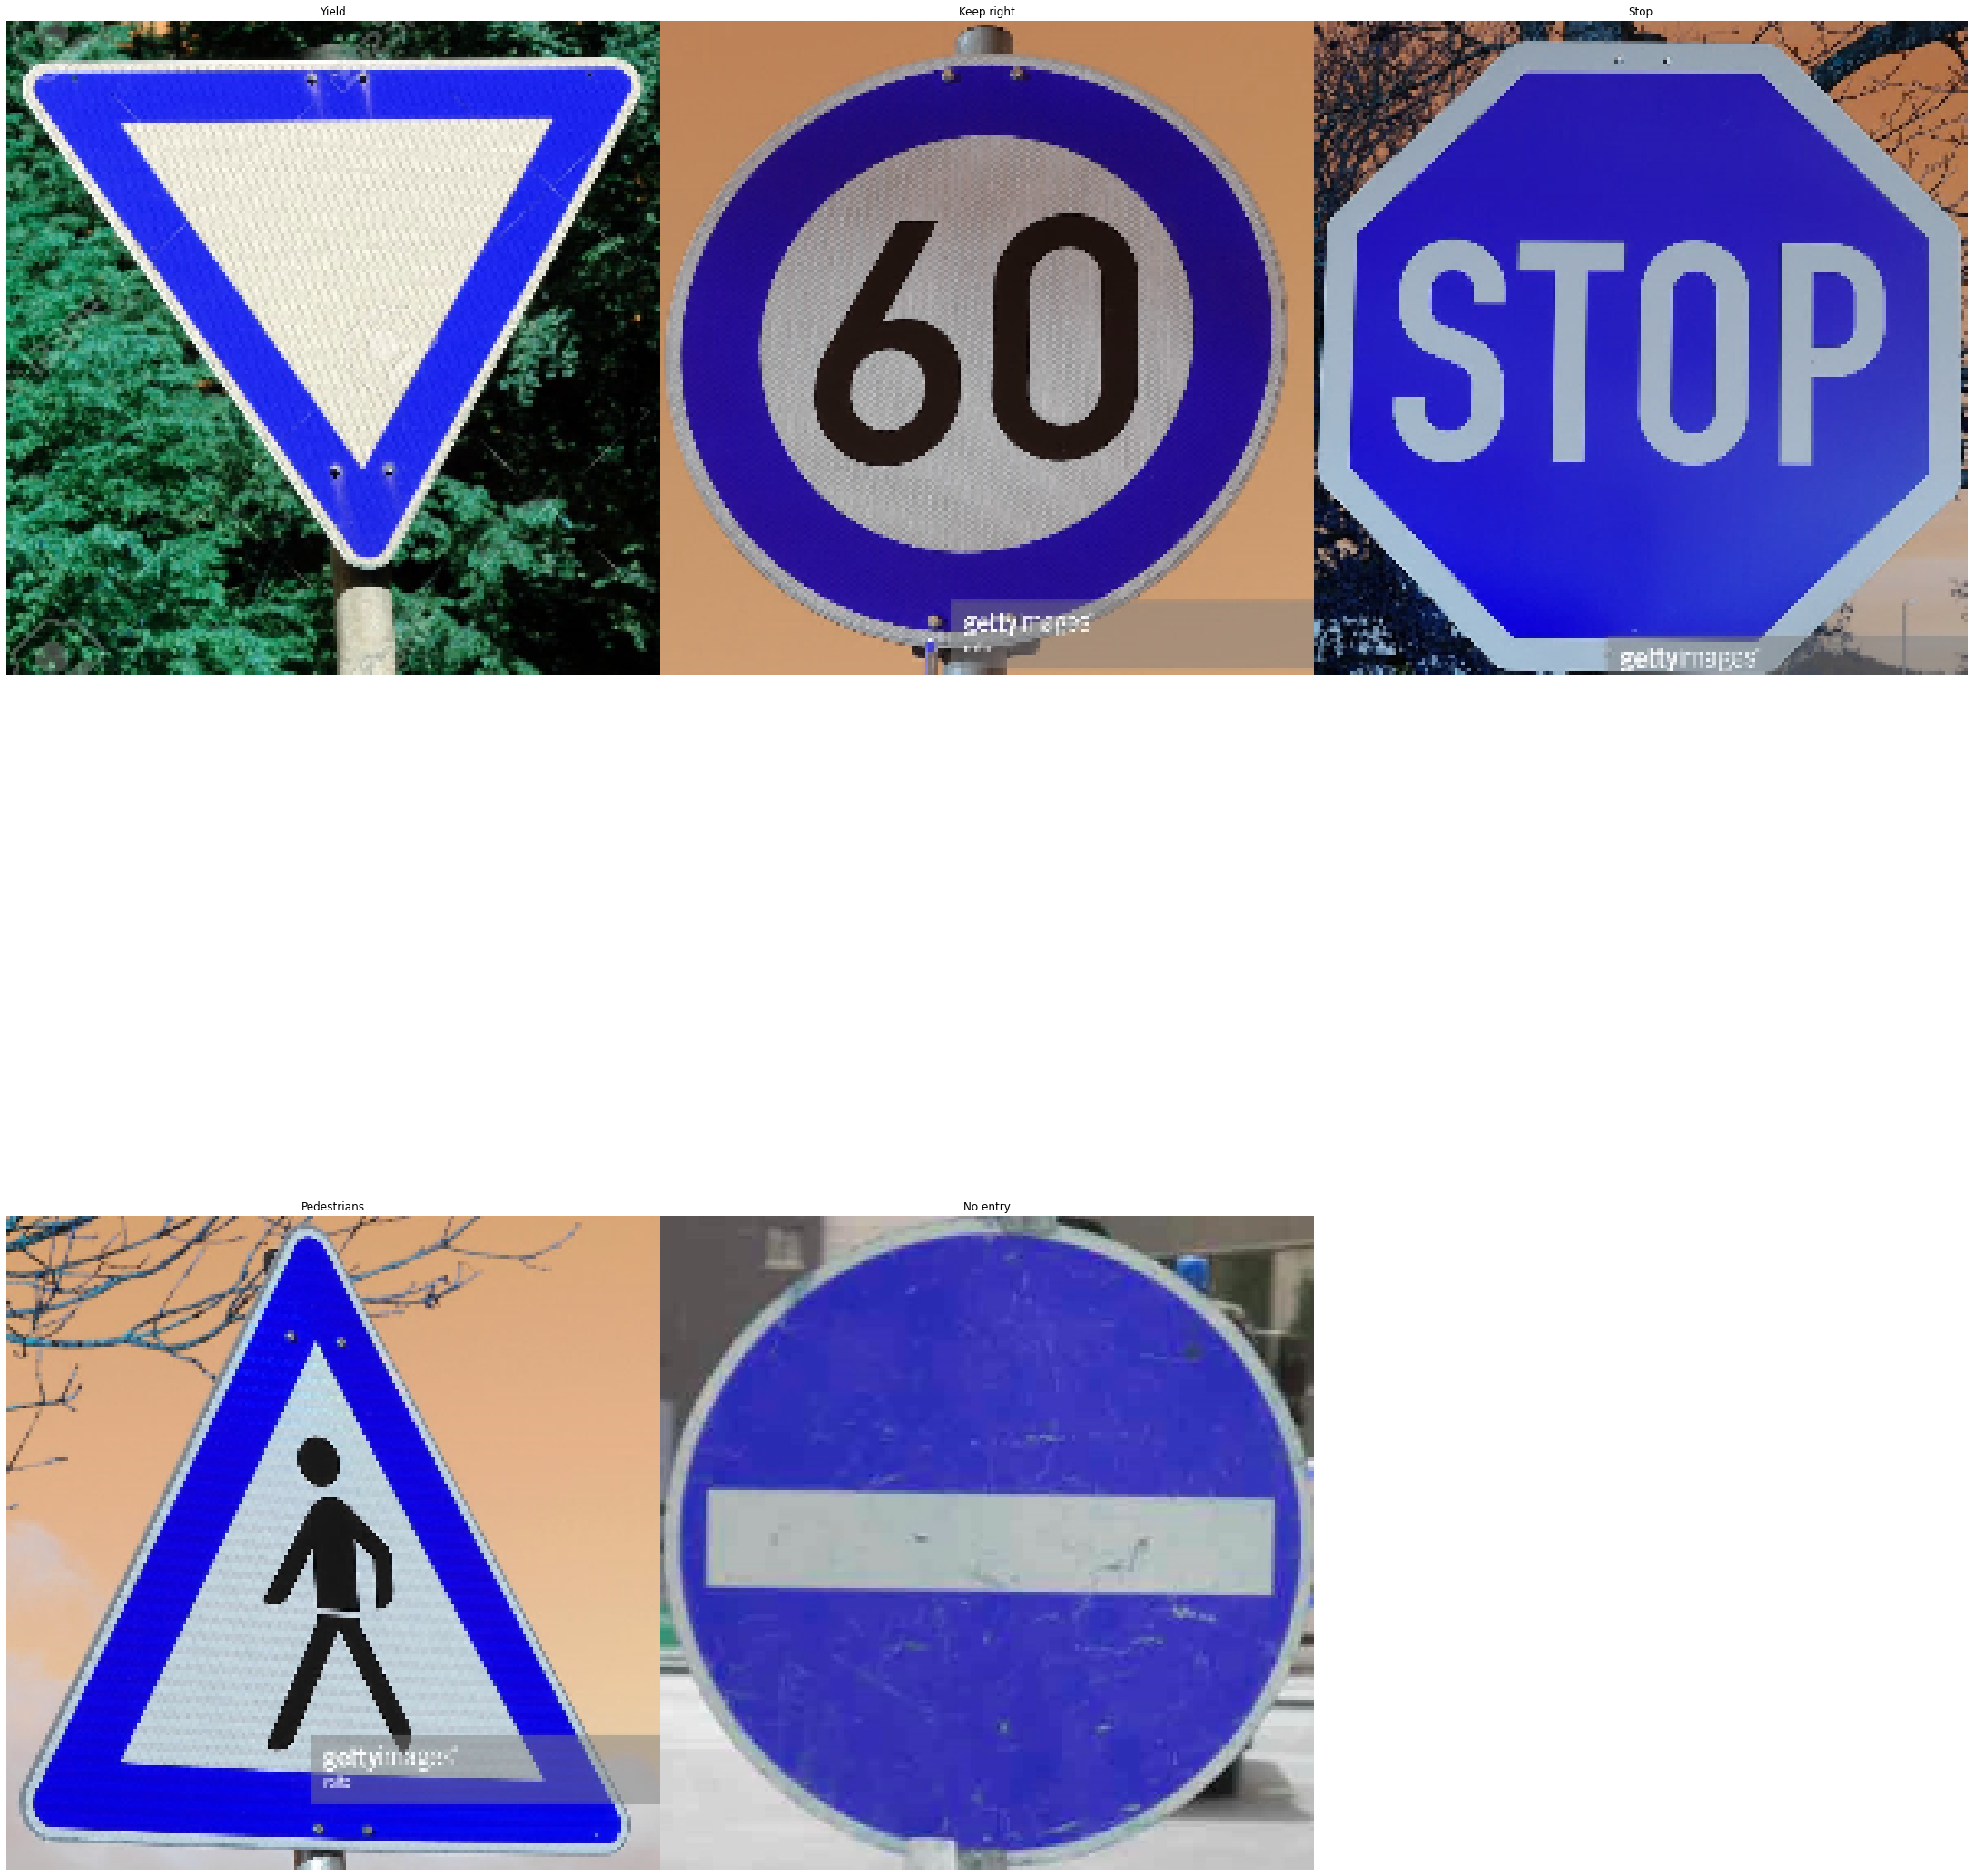

In [150]:
plt.figure(figsize=(30,40))
for i in range(1,6):
        plt.subplot(2,3,i)
        k=str(i)
        img = cv2.imread("../input/new-image/00"+k+".jpg")
        temp_img = cv2.resize(img,(32,32))
        temp_img = test_preprocess(temp_img)
        y_pred = model_conv.predict_classes(temp_img)
        img = cv2.resize(img,(200,200))
        plt.imshow(img)
        plt.title(signs[y_pred[0]])
        plt.axis('off')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()